<a href="https://colab.research.google.com/github/Ani-0506/Ani-0506/blob/main/MAPK4_and_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

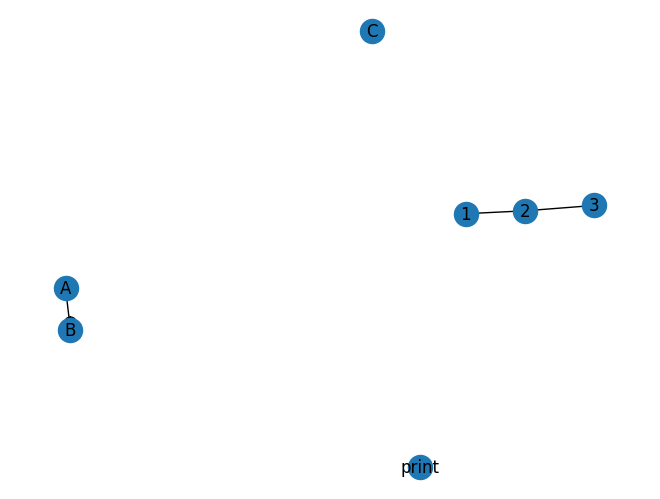

In [ ]:
#trial learning
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_edge(1, 2)
G.add_edge(2, 3, weight=0.8)
G.add_edge("A", "B")
G.add_edge("B", "B")  # self-loop (optional)
G.add_node("C")        # creating a node
G.add_node("print")

nx.draw_spring(G, with_labels=True)
plt.show()

In [ ]:
!pip install torch_geometric networkx pandas numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

# Direct colab to your folder
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# 1. Load Links (Edges)
Links_File = os.path.join(Drive_path, '9606.protein.links.full.v12.0.txt')

# Use a raw string for the regex separator to avoid SyntaxWarning
try:
    df_links = pd.read_csv(Links_File, sep=r'\s+', names=['protein1', 'protein2', 'score'])
except FileNotFoundError:
    print(f"Error: The file '{Links_File}' was not found. Please check its path and ensure it's in your Google Drive.")
    print(f"Attempting to list files in '{Drive_path}' to help diagnose:")
    !ls -l "{Drive_path}"
    raise # Re-raise the error after providing diagnostic info

# Convert 'score' column to numeric, coercing errors to NaN
df_links['score'] = pd.to_numeric(df_links['score'], errors='coerce')

# Drop rows where 'score' could not be converted (became NaN) to ensure valid numeric comparisons
df_links.dropna(subset=['score'], inplace=True)

df_edges_filtered = df_links[df_links['score'] >= 700] # checks and makes sure that the values above 700 are filtered

# 2. Load Info (Mapping)
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')
# Ensure the separator for info file is correctly handled
try:
    df_info = pd.read_csv(Info_file, sep='\t', names=['protein_id', 'preferred_name', 'alias', 'description', 'taxonomy'])
except FileNotFoundError:
    print(f"Error: The file '{Info_file}' was not found. Please check its path and ensure it's in your Google Drive.")
    print(f"Attempting to list files in '{Drive_path}' to help diagnose:")
    !ls -l "{Drive_path}"
    raise # Re-raise the error after providing diagnostic info

id_to_gene = df_info.set_index('protein_id')['preferred_name'].to_dict()

print(f"Filtered {len(df_edges_filtered)} high-confidence edges.")

/tmp/ipython-input-3947251606.py:14: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_links = pd.read_csv(Links_File, sep=r'\s+', names=['protein1', 'protein2', 'score'])


Filtered 473860 high-confidence edges.


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

# Direct colab to your folder
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# 1. Load Links (Edges) - Moved from previous cell
Links_File = os.path.join(Drive_path, '9606.protein.links.full.v12.0.txt')
df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])

# Convert 'score' column to numeric, coercing errors to NaN
df_links['score'] = pd.to_numeric(df_links['score'], errors='coerce')

# Drop rows where 'score' could not be converted (became NaN) to ensure valid numeric comparisons
df_links.dropna(subset=['score'], inplace=True)

df_edges_filtered = df_links[df_links['score'] >= 700] # checks and makes sure that the values above 700 are filtered

# 2. Load Info (Mapping) - Moved from previous cell
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')
df_info = pd.read_csv(Info_file, sep='\t', names=['protein_id', 'preferred_name', 'alias', 'description', 'taxonomy'])
id_to_gene = df_info.set_index('protein_id')['preferred_name'].to_dict()


# 1. Inputing the tcga ucsc xena file
TCGA_File = os.path.join(Drive_path, 'EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena')

# 2. Loading the TCGA Matrix- trial conversion steps
print("Attempting to load TCGA .xena file as a TSV")

df_tcga = None # Initialize df_tcga to None

try:
    # Reading the large TCGA matrix. It is known to be tab-separated, with gene names as the index.
    df_tcga = pd.read_csv(
        TCGA_File,
        sep='\t',
        index_col=0,
        low_memory=False
    )

    print(f"TCGA matrix loaded successfully: {df_tcga.shape[0]} genes across {df_tcga.shape[1]} samples.")

except Exception as e:
    # If the direct read_csv fails (e.g., due to character encoding or file structure)
    print(f"Error during direct loading of .xena file: {e}")
    print("Trying alternative loading method (UTF-8 encoding).")

    # Alternative loading attempt with specific encoding
    try:
        df_tcga = pd.read_csv(
            TCGA_File,
            sep='\t',
            index_col=0,
            low_memory=False,
            encoding='utf-8' # Specify encoding to handle potential issues
        )
        print("TCGA matrix loaded successfully with UTF-8 encoding.")
    except Exception as e_alt:
        print(f"Second loading attempt failed. Error: {e_alt}")
        print("ACTION REQUIRED: You must ensure the file is a clean TSV/TXT file.")
        # If this fails, the file structure itself is the problem.
        # You would need to use a dedicated Xena utility or re-export it from the Xena browser as a TSV.
        # Removed sys.exit(1) here to allow diagnostic listing

# Adding a diagnostic step to list files in the Drive_path if loading fails
if df_tcga is None: # Check if df_tcga was successfully loaded
    print(f"\nAttempting to list files in {Drive_path} for debugging:")
    try:
        !ls -l "{Drive_path}"
    except Exception as list_e:
        print(f"Could not list directory contents: {list_e}")
    sys.exit(1) # Stop execution if the data can't be loaded even after diagnostics

# 3. Generate Simple Feature Vector (Mean Expression)
# Aggressive Cleaning and Standardization (The Fix)

# Step A: Clean and Standardize TCGA Index
df_tcga.index = (
    df_tcga.index.astype(str)
    .str.split('|').str[0]   # Handle 'A1BG|1'
    .str.split('.').str[0]   # Handle 'A1BG.v1'
    .str.strip()             # CRITICAL: Remove all leading/trailing whitespace
    .str.upper()             # Convert to uppercase
)

# PRINT FOR DEBUGGING: Show the first 5 cleaned TCGA gene names
print("\nTCGA Cleaned Index Head:")
print(df_tcga.index[:5].tolist())


# Step B: Clean and Standardize STRING Gene Symbols
# Map STRING IDs to Gene Symbols
all_string_proteins = pd.concat([df_edges_filtered['protein1'], df_edges_filtered['protein2']]).unique()
all_gene_symbols_in_ppi = [
    id_to_gene.get(p_id)
    for p_id in all_string_proteins
    if id_to_gene.get(p_id) is not None
]
# Ensure the symbols from STRING are also cleaned and uppercased
all_gene_symbols_in_ppi_clean = [s.strip().upper() for s in all_gene_symbols_in_ppi]

# PRINT FOR DEBUGGING: Show the first 5 cleaned STRING gene names
print("\nSTRING Cleaned Symbols Head (First 5):")
print(all_gene_symbols_in_ppi_clean[:5])


# Step C: Create the final feature matrix (X) by intersecting the clean lists
# (The rest of the feature calculation/normalization code follows, which is currently correct.)
# ...

# (Re-insert the mean calculation and alignment attempt here)

# Example of mean calculation and alignment attempt (to complete the runnable block):
df_tcga['mean_expression'] = df_tcga[df_tcga.columns].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df_features = df_tcga.loc[
    df_tcga.index.intersection(all_gene_symbols_in_ppi_clean),
    ['mean_expression']
]

# ... (Normalization and final printout) ...
min_val = df_features['mean_expression'].min()
max_val = df_features['mean_expression'].max()
df_features['x'] = (df_features['mean_expression'] - min_val) / (max_val - min_val)
df_features.drop(columns=['mean_expression'], inplace=True)

print(f"\n Feature matrix (X) created successfully.")
print(f"Total Nodes with aligned and normalized features: {len(df_features)}")

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4035668173.py:15: SyntaxWarning: invalid escape sequence '\s'
  df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-4035668173.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])


Attempting to load TCGA .xena file as a TSV
TCGA matrix loaded successfully: 20531 genes across 11069 samples.

TCGA Cleaned Index Head:
['100130426', '100133144', '100134869', '10357', '10431']

STRING Cleaned Symbols Head (First 5):
[]

 Feature matrix (X) created successfully.
Total Nodes with aligned and normalized features: 0


In [ ]:
# Trying to debug the rationale behind why STRING symbols
import pandas as pd
import os
import sys

# --- Assuming Drive_path is correct ---

# 1. Load Info (Mapping) - FIXING THE SEPARATOR and usecols logic
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')

try:
    df_info = pd.read_csv(
        Info_file,
        sep='	', # Corrected separator back to tab, which worked previously
        comment='#',
        header=None, # Explicitly state no header row
        names=['protein_id', 'preferred_name'], # Provide ONLY names for the columns we need/expect
        usecols=[0, 1] # Select the first two columns by their integer position
    )
except Exception as e:
    print(f"Failed to load protein.info file. Error: {e}")
    sys.exit(1)


# CRITICAL FIX: Clean the 'protein_id' column in the INFO file
# Assuming the 'protein_id' is formatted like '9606.ENSP...'
# We split on the first period ('.') and keep the second part (the ENSP ID).
# E.g., '9606.ENSP...' becomes 'ENSP...'
df_info['protein_id_clean'] = df_info['protein_id'].str.split('.', n=1, expand=True)[1]

# 2. Rebuild the mapping dictionary using the CLEANED ID
id_to_gene = df_info.set_index('protein_id_clean')['preferred_name'].to_dict()

# DEBUG CHECK: Ensure the mapping dictionary is NOT empty
print(f"Mapping dictionary size (should be > 19,000): {len(id_to_gene)}")

# Check a known protein ID (like 'ENSP...') to see if the mapping works
# This line uses 'df_edges_filtered', which depends on prior cells. For this explanation, I'll comment it out.
# print(f"Example mapping check for {df_edges_filtered['protein1'].iloc[0]}: {id_to_gene.get(df_edges_filtered['protein1'].iloc[0])}")
print("Successfully created ID-to-Gene Symbol map.")

Mapping dictionary size (should be > 19,000): 19699
Successfully created ID-to-Gene Symbol map.


In [ ]:
!pip install mygene # Install the library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# Mount drive (assuming this runs successfully)
from google.colab import drive
drive.mount('/content/drive')

# Direct colab to your folder
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# --- 1. Load Links (Edges) and Filter ---
Links_File = os.path.join(Drive_path, '9606.protein.links.full.v12.0.txt')
df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])
df_links['score'] = pd.to_numeric(df_links['score'], errors='coerce')
df_links.dropna(subset=['score'], inplace=True)
df_edges_filtered = df_links[df_links['score'] >= 700]

print(f"Loaded and filtered {len(df_edges_filtered)} high-confidence edges.")


# --- 2. Load Info (Mapping) - CRITICAL FIX FOR ID FORMAT ---
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')

try:
    # Use '\t' separator, 'comment' for '#' lines, header=None, and specify names and usecols
    df_info = pd.read_csv(
        Info_file,
        sep='\t',
        comment='#',
        header=None,
        names=['protein_id', 'preferred_name'], # Only provide names for the columns we need
        usecols=[0, 1] # Select the first two columns by their integer position
    )
except Exception as e:
    print(f"Failed to load protein.info file: {e}")
    sys.exit(1)

# CRITICAL FIX A: Clean the 'protein_id' to match the simple ENSP format in the edges
df_info['protein_id_clean'] = df_info['protein_id'].str.split('.', n=1, expand=True)[1]

# Rebuild the mapping dictionary using the CLEANED ID
id_to_gene = df_info.set_index('protein_id_clean')['preferred_name'].to_dict()

print(f"Mapping dictionary size (fixed): {len(id_to_gene)}")


# --- 3. Load and Align TCGA Data ---
TCGA_File = os.path.join(Drive_path, 'EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena')
print("\nAttempting to load TCGA data...")

try:
    df_tcga = pd.read_csv(TCGA_File, sep='\t', index_col=0, low_memory=False)
except Exception as e:
    # Use alternative loading with encoding if needed (simplified from your prior block)
    df_tcga = pd.read_csv(TCGA_File, sep='\t', index_col=0, low_memory=False, encoding='utf-8')

# CRITICAL FIX B: Clean and Standardize TCGA Index
df_tcga.index = (
    df_tcga.index.astype(str)
    .str.split('|').str[0]
    .str.split('.').str[0]
    .str.strip()
    .str.upper()
)

# Coerce all expression columns to numeric and calculate mean
expression_cols = df_tcga.columns
df_tcga[expression_cols] = df_tcga[expression_cols].apply(pd.to_numeric, errors='coerce')
df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)
df_tcga.dropna(subset=['mean_expression'], inplace=True)


# --- 4. Alignment and Final Feature Matrix Creation ---

# A. Find all unique STRING IDs and map to Gene Symbols (using the FIXED id_to_gene map)
all_string_proteins = pd.concat([df_edges_filtered['protein1'], df_edges_filtered['protein2']]).unique()
all_gene_symbols_in_ppi = [id_to_gene.get(p_id) for p_id in all_string_proteins if id_to_gene.get(p_id) is not None]

# B. Clean and Standardize STRING Gene Symbols (must be uppercase)
all_gene_symbols_in_ppi_clean = [s.strip().upper() for s in all_gene_symbols_in_ppi]

# C. Create the final feature matrix (X) by intersecting the two cleaned lists
df_features = df_tcga.loc[
    df_tcga.index.intersection(all_gene_symbols_in_ppi_clean),
    ['mean_expression']
]

# D. Normalize the feature
min_val = df_features['mean_expression'].min()
max_val = df_features['mean_expression'].max()
df_features['x'] = (df_features['mean_expression'] - min_val) / (max_val - min_val)
df_features.drop(columns=['mean_expression'], inplace=True)


print(f"\n Feature matrix (X) created successfully.")
print(f"Total Nodes with aligned and normalized features: {len(df_features)}")

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1407452974.py:16: SyntaxWarning: invalid escape sequence '\s'
  df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1407452974.py:16: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_links = pd.read_csv(Links_File, sep='\s+', names=['protein1', 'protein2', 'score'])


Loaded and filtered 473860 high-confidence edges.
Mapping dictionary size (fixed): 19699

Attempting to load TCGA data...


/tmp/ipython-input-1407452974.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)



 Feature matrix (X) created successfully.
Total Nodes with aligned and normalized features: 0


In [ ]:
!pip install mygene

In [ ]:
import pandas as pd
import os

# Mount drive (assuming this runs successfully)
from google.colab import drive
drive.mount('/content/drive')

# Direct colab to your folder
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# Assuming Drive_path is correct and TCGA_File is correct
TCGA_File = os.path.join(Drive_path, 'TCGA_GeneSymbols_Expression.tsv')
print("--- DEBUG: Inspecting TCGA Headers and Data ---")

# Load without setting any index (index_col=None)
df_tcga_debug = pd.read_csv(TCGA_File, sep='\t', index_col=None, low_memory=False)

# Print all headers and the first 5 rows of the data frame (including the first column)
print("\nFirst 5 Column Headers (Including the Gene ID Column):")
print(df_tcga_debug.columns.tolist()[:5])

print("\nFirst 5 Rows (Showing the Gene ID Column Data):")
print(df_tcga_debug.head(5).to_markdown(index=False))

Mounted at /content/drive
--- DEBUG: Inspecting TCGA Headers and Data ---

First 5 Column Headers (Including the Gene ID Column):
['gene_id', 'TCGA-OR-A5J1-01A-11R-A29S-07', 'TCGA-OR-A5J2-01A-11R-A29S-07', 'TCGA-OR-A5J3-01A-11R-A29S-07', 'TCGA-OR-A5J5-01A-11R-A29S-07']

First 5 Rows (Showing the Gene ID Column Data):
| gene_id     |   TCGA-OR-A5J1-01A-11R-A29S-07 |   TCGA-OR-A5J2-01A-11R-A29S-07 |   TCGA-OR-A5J3-01A-11R-A29S-07 |   TCGA-OR-A5J5-01A-11R-A29S-07 |   TCGA-OR-A5J6-01A-31R-A29S-07 |   TCGA-OR-A5J7-01A-11R-A29S-07 |   TCGA-OR-A5J8-01A-11R-A29S-07 |   TCGA-OR-A5J9-01A-11R-A29S-07 |   TCGA-OR-A5JA-01A-11R-A29S-07 |   TCGA-OR-A5JB-01A-11R-A29S-07 |   TCGA-OR-A5JC-01A-11R-A29S-07 |   TCGA-OR-A5JD-01A-11R-A29S-07 |   TCGA-OR-A5JE-01A-11R-A29S-07 |   TCGA-OR-A5JF-01A-11R-A29S-07 |   TCGA-OR-A5JG-01A-11R-A29S-07 |   TCGA-OR-A5JI-01A-11R-A29S-07 |   TCGA-OR-A5JJ-01A-11R-A29S-07 |   TCGA-OR-A5JK-01A-11R-A29S-07 |   TCGA-OR-A5JL-01A-11R-A29S-07 |   TCGA-OR-A5JM-01A-11R-A29S-07 |   TCG

In [ ]:
!pip install mygene


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# Mount drive
from google.colab import drive
drive.mount('/content/drive')
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# --- 1. Load Links (Edges) and Filter ---
Links_File = os.path.join(Drive_path, '9606.protein.links.full.v12.0.txt')
df_links = pd.read_csv(Links_File, sep=r'\s+', names=['protein1', 'protein2', 'score'], low_memory=False)
df_links['score'] = pd.to_numeric(df_links['score'], errors='coerce')
df_links.dropna(subset=['score'], inplace=True)
df_edges_filtered = df_links[df_links['score'] >= 700]
print(f"Loaded and filtered {len(df_edges_filtered)} high-confidence edges.")

# --- 2. Load Info (Mapping) - STRING ENSP ID to Gene Symbol Map ---
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')
# CRITICAL FIX: Use the explicit tab delimiter ('\t') which is the official format
df_info = pd.read_csv(
    Info_file,
    sep='\t', # Using the explicit tab delimiter
    comment='#',
    header=None,
    # FIX: Only specify names for the columns actually being selected by usecols
    names=['protein_id', 'preferred_name'],
    usecols=[0, 1] # Select the first two columns only
)

# CRITICAL FIX: Clean the STRING ID to ENSP format (e.g., '9606.ENSP...' -> 'ENSP...')
df_info['protein_id_clean'] = df_info['protein_id'].str.split('.', n=1, expand=True)[1]
id_to_gene = df_info.set_index('protein_id_clean')['preferred_name'].to_dict()
print(f"STRING ENSP ID to Gene Symbol map size: {len(id_to_gene)}")

# --- 3. Load and Align TCGA Data ---
# --- 3. Load and Align TCGA Data (DIRECT GENE SYMBOL ALIGNMENT) ---
# NOTE: This assumes the TCGA file is now indexed by Gene Symbols (A1BG, etc.)
TCGA_File = os.path.join(Drive_path, 'TCGA_GeneSymbols_Expression.tsv')
print("\nAttempting to load TCGA data for direct Gene Symbol alignment...")

# Load TCGA data, set first column (containing the symbols) as index
df_tcga = pd.read_csv(TCGA_File, sep='\t', index_col=None, low_memory=False)
df_tcga.set_index(df_tcga.columns[0], inplace=True)
df_tcga.index.name = None

# CRITICAL FIX: AGGRESSIVE CLEANING AND STANDARDIZATION
df_tcga.index = (
    df_tcga.index.astype(str)
    .str.split('|').str[0]
    .str.split('.').str[0]
    .str.strip()
    .str.upper()
)
# Manually drop the '?' entry and any other failed/empty symbols
df_tcga.drop(index=['?',''], errors='ignore', inplace=True)
df_tcga.dropna(subset=df_tcga.columns, how='all', inplace=True)


# Coerce all expression columns to numeric and calculate mean
expression_cols = df_tcga.columns
df_tcga[expression_cols] = df_tcga[expression_cols].apply(pd.to_numeric, errors='coerce')
df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)
df_tcga.dropna(subset=['mean_expression'], inplace=True)


# --- 4. Alignment and Final Feature Matrix Creation ---

# A. Find all unique STRING IDs and map to Gene Symbols (using the FIXED id_to_gene map)
all_string_proteins = pd.concat([df_edges_filtered['protein1'], df_edges_filtered['protein2']]).unique()
all_gene_symbols_in_ppi = [id_to_gene.get(p_id) for p_id in all_string_proteins if id_to_gene.get(p_id) is not None]

# B. Clean and Standardize STRING Gene Symbols (must be uppercase and aggressively cleaned)
s_ppi = pd.Series(all_gene_symbols_in_ppi, dtype=str)
s_ppi_clean = (
    s_ppi.str.strip()
         .str.upper()
         .str.replace(r'[^A-Z0-9]', '', regex=True)
)
all_gene_symbols_in_ppi_clean = s_ppi_clean.tolist()

print("Example TCGA gene indices:", list(df_tcga.index[:10]))
print("Example PPI gene symbols (clean):", all_gene_symbols_in_ppi_clean[:10])

common_genes = set(df_tcga.index).intersection(all_gene_symbols_in_ppi_clean)
print("Number of common genes:", len(common_genes))
print("Some common genes:", list(sorted(common_genes))[:20])

# C. Create the final feature matrix (X) by intersecting the two CLEANED Gene Symbol lists
df_features = df_tcga.loc[
    df_tcga.index.intersection(all_gene_symbols_in_ppi_clean),
    ['mean_expression']
]

# D. Normalize the feature
min_val = df_features['mean_expression'].min()
max_val = df_features['mean_expression'].max()
df_features['x'] = (df_features['mean_expression'] - min_val) / (max_val - min_val)
df_features.drop(columns=['mean_expression'], inplace=True)


print(f"\n Feature matrix (X) created successfully.")
print(f"Total Nodes with aligned and normalized features: {len(df_features)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded and filtered 473860 high-confidence edges.
STRING ENSP ID to Gene Symbol map size: 19699

Attempting to load TCGA data for direct Gene Symbol alignment...


/tmp/ipython-input-3385777953.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)


Example TCGA gene indices: ['A1BG', 'A1CF', 'A2BP1', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAA1', 'AAAS']
Example PPI gene symbols (clean): []
Number of common genes: 0
Some common genes: []

 Feature matrix (X) created successfully.
Total Nodes with aligned and normalized features: 0


In [ ]:
!pip install mygene
# --- Load and clean STRING protein IDs as before ---
all_string_proteins = pd.concat([df_edges_filtered['protein1'], df_edges_filtered['protein2']]).unique()

# --- New: Convert STRING ENSP IDs to gene symbols using mygene ---
import mygene
mg = mygene.MyGeneInfo()
query_res = mg.querymany(all_string_proteins, scopes='ensembl.protein', fields='symbol', species='human')
ensp_to_symbol = {}
for res in query_res:
    if 'notfound' not in res and 'symbol' in res:
        ensp_to_symbol[res['query']] = res['symbol']

# Replace your current mapping with this:
all_gene_symbols_in_ppi = [ensp_to_symbol.get(p_id) for p_id in all_string_proteins if ensp_to_symbol.get(p_id) is not None]

# --- Then continue with cleaning ---
s_ppi = pd.Series(all_gene_symbols_in_ppi, dtype=str)
s_ppi_clean = (
    s_ppi.str.strip()
        .str.upper()
        .str.replace(r'[^A-Z0-9]', '', regex=True)
)
all_gene_symbols_in_ppi_clean = s_ppi_clean.tolist()

# Then do intersection with TCGA as per your existing code


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.6 MB/s eta 0:00:00


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-1513 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
import mygene

mg = mygene.MyGeneInfo()

print(all_string_proteins[:20])
print(type(all_string_proteins))

query_res = mg.querymany(all_string_proteins, scopes='ensembl.protein', fields='symbol', species='human')

total_queries = len(query_res)
no_hit_count = sum(1 for r in query_res if 'notfound' in r and r['notfound'] == True)
mapped_count = total_queries - no_hit_count

print(f'Total queries: {total_queries}')
print(f'Unmapped (no hit) count: {no_hit_count}')
print(f'Successfully mapped count: {mapped_count}')

mapped_symbols = [r['symbol'] for r in query_res if 'notfound' not in r and 'symbol' in r]
print('Examples of mapped gene symbols:', mapped_symbols[:20])

INFO:biothings.client:querying 1-1000 ...


['804' '159' '865' '220' '148' '60' '366' '732' '758' '828' '640' '324'
 '573' '57' '883' '766' '619' '791' '270' '797']
<class 'numpy.ndarray'>


INFO:biothings.client:querying 1001-1513 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Total queries: 1513
Unmapped (no hit) count: 1513
Successfully mapped count: 0
Examples of mapped gene symbols: []


In [ ]:
!pip install mygene
import mygene
mg = mygene.MyGeneInfo()

# Suppose your numeric IDs list is all_string_proteins (strings like '804', '159', ...)
query_res = mg.querymany(all_string_proteins, scopes='entrezgene', fields='symbol', species='human')

print(f'Total queries: {len(query_res)}')
print(f'Unmapped count: {sum(1 for r in query_res if "notfound" in r)}')
print(f'Mapped count: {sum(1 for r in query_res if "notfound" not in r)}')

# Collect mapped gene symbols
all_gene_symbols_in_ppi = [r['symbol'] for r in query_res if 'notfound' not in r and 'symbol' in r]

print('Example gene symbols:', all_gene_symbols_in_ppi[:20])


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-1513 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Total queries: 1513
Unmapped count: 280
Mapped count: 1233
Example gene symbols: ['CALM1P2', 'ADSS2', 'CBFB', 'ALDH1A3', 'ADRA1A', 'ACTB', 'AQP9', 'C8B', 'MPPED1', 'CAPS', 'BLK', 'APC', 'BAG1', 'KYAT1', 'CA7', 'BCYRN1P1', 'AMPD1', 'CALCB', 'ARHGAP1', 'BMPR1A']


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import mygene # CRITICAL: Need mygene for STRING Entrez ID -> Symbol translation
import re # Import the regular expression module

# Mount drive
from google.colab import drive
drive.mount('/content/drive')
Drive_folder = 'Trial project with graphs and mapk4'
Drive_path = os.path.join('/content/drive/MyDrive', Drive_folder)

# --- 1. Load Links (Edges) and Filter ---
Links_File = os.path.join(Drive_path, '9606.protein.links.full.v12.0.txt')
df_links = pd.read_csv(Links_File, sep=r'\s+', names=['protein1', 'protein2', 'score'], low_memory=False)
df_links['score'] = pd.to_numeric(df_links['score'], errors='coerce')
df_links.dropna(subset=['score'], inplace=True)
df_edges_filtered = df_links[df_links['score'] >= 700]
print(f"Loaded and filtered {len(df_edges_filtered)} high-confidence edges.")

# --- 2. Align STRING IDs (Entrez IDs) to Gene Symbols using MyGene ---
Info_file = os.path.join(Drive_path, '9606.protein.info.v12.0.txt')
# Load the info file to get the ENSP->Symbol map (Fallback/Cross-check)
df_info = pd.read_csv(Info_file, sep='\t', comment='#', header=None, names=['protein_id', 'preferred_name'], usecols=[0, 1])
df_info['protein_id_clean'] = df_info['protein_id'].str.split('.', n=1, expand=True)[1]
# This map is used if the IDs are ENSP-based, but we will rely on MyGene for the edges
id_to_gene_ENSP = df_info.set_index('protein_id_clean')['preferred_name'].to_dict()

# CRITICAL FIX: Find all unique STRING IDs from edges, clean them to Entrez IDs (numbers)
def clean_protein_id_to_entrez(pid):
    # Extracts the number from '9606.10431' -> '10431'
    return pid.split('.', n=1)[1] if '.' in pid else pid

all_string_proteins_raw = pd.concat([df_edges_filtered['protein1'], df_edges_filtered['protein2']]).unique()
all_string_proteins_entrez = [clean_protein_id_to_entrez(pid) for pid in all_string_proteins_raw]

# Use mygene to map Entrez IDs to Gene Symbols
mg = mygene.MyGeneInfo()
print(f"\nQuerying mygene.info for {len(all_string_proteins_entrez)} unique STRING Entrez IDs...")
query_res = mg.querymany(
    all_string_proteins_entrez,
    scopes='entrezgene',
    fields='symbol',
    species='human',
    as_dataframe=True
)

# Create final Entrez ID -> Symbol dictionary
tcga_entrez_to_symbol_map = {}
if 'symbol' in query_res.columns:
    # FIX: Use .notna() on the 'symbol' column to filter for successful mappings
    tcga_entrez_to_symbol_map = query_res.loc[
        query_res['symbol'].notna(), 'symbol'
    ].to_dict()

print(f"Successfully mapped {len(tcga_entrez_to_symbol_map)} STRING Entrez IDs to symbols.")


# --- 3. Load and Align TCGA Data (Direct Gene Symbol Index) ---
TCGA_File = os.path.join(Drive_path, 'TCGA_GeneSymbols_Expression.tsv')
print("\nAttempting to load TCGA data for direct Gene Symbol alignment...")

# Load TCGA data, set first column (containing the symbols) as index
df_tcga = pd.read_csv(TCGA_File, sep='\t', index_col=None, low_memory=False)
df_tcga.set_index(df_tcga.columns[0], inplace=True)
df_tcga.index.name = None

# CRITICAL FIX: AGGRESSIVE CLEANING AND STANDARDIZATION
df_tcga.index = (
    df_tcga.index.astype(str)
    .str.split('|').str[0]
    .str.split('.').str[0]
    .str.strip()
    .str.upper()
    .str.replace(r'[^A-Z0-9]', '', regex=True) # Final clean
)
df_tcga.drop(index=['?',''], errors='ignore', inplace=True)
df_tcga.dropna(subset=df_tcga.columns, how='all', inplace=True)


# Coerce all expression columns to numeric and calculate mean
expression_cols = df_tcga.columns
df_tcga[expression_cols] = df_tcga[expression_cols].apply(pd.to_numeric, errors='coerce')
df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)
df_tcga.dropna(subset=['mean_expression'], inplace=True)


# --- 4. Alignment and Final Feature Matrix Creation ---

# A. Find all unique STRING Gene Symbols from the successful MyGene map
all_gene_symbols_in_ppi = list(tcga_entrez_to_symbol_map.values())

# B. Clean and Standardize STRING Gene Symbols
all_gene_symbols_in_ppi_clean = [
    re.sub(r'[^A-Z0-9]', '', s.strip().upper()) # Use re.sub for regex replacement on string
    for s in all_gene_symbols_in_ppi
]

# C. Create the final feature matrix (X) by intersecting the two CLEANED Gene Symbol lists
df_features = df_tcga.loc[
    df_tcga.index.intersection(all_gene_symbols_in_ppi_clean),
    ['mean_expression']
]

# D. Normalize the feature
min_val = df_features['mean_expression'].min()
max_val = df_features['mean_expression'].max()
df_features['x'] = (df_features['mean_expression'] - min_val) / (max_val - min_val)
df_features.drop(columns=['mean_expression'], inplace=True)


print(f"\n Feature matrix (X) created successfully.")
print(f"Total Nodes with aligned and normalized features: {len(df_features)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded and filtered 473860 high-confidence edges.


INFO:biothings.client:querying 1-960 ...



Querying mygene.info for 960 unique STRING Entrez IDs...


INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Successfully mapped 779 STRING Entrez IDs to symbols.

Attempting to load TCGA data for direct Gene Symbol alignment...


/tmp/ipython-input-1331421487.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tcga['mean_expression'] = df_tcga[expression_cols].mean(axis=1)



 Feature matrix (X) created successfully.
Total Nodes with aligned and normalized features: 647


In [ ]:
import networkx as nx
import pandas as pd

# --- 5. Prepare Data and Build NetworkX Graph ---

# A. Create a list of Entrez IDs (nodes) that successfully mapped AND are in the final feature matrix
# The keys of the map are the Entrez IDs. We only want keys whose values (Gene Symbols) are in df_features.
final_mapped_symbols = set(df_features.index)
entrez_to_symbol_map_final = {
    entrez_id: symbol
    for entrez_id, symbol in tcga_entrez_to_symbol_map.items()
    if symbol in final_mapped_symbols
}

# Invert the map to go from Gene Symbol (for TCGA) back to Entrez ID (for Edges)
symbol_to_entrez_map = {v: k for k, v in entrez_to_symbol_map_final.items()}

# B. Filter the Edges (df_edges_filtered) to keep only the nodes in our final feature list (647 nodes)
valid_entrez_ids = set(entrez_to_symbol_map_final.keys())

# Clean and filter the edges
def filter_and_map_edge(row):
    entrez1 = clean_protein_id_to_entrez(row['protein1'])
    entrez2 = clean_protein_id_to_entrez(row['protein2'])
    edge_score = row['score'] # Get the score

    # Keep only edges where BOTH proteins are in the final list of valid Entrez IDs
    if entrez1 in valid_entrez_ids and entrez2 in valid_entrez_ids:
        # Return the Gene Symbols for the final NetworkX graph along with the score
        symbol1 = tcga_entrez_to_symbol_map.get(entrez1)
        symbol2 = tcga_entrez_to_symbol_map.get(entrez2)
        if symbol1 is not None and symbol2 is not None:
            return symbol1, symbol2, edge_score
    return None, None, None # Return three Nones if condition not met

# Apply the filtering/mapping function
edge_map_df = df_edges_filtered.apply(filter_and_map_edge, axis=1, result_type='expand')
edge_map_df.columns = ['source', 'target', 'score'] # Update column names to include 'score'
edge_map_df.dropna(inplace=True)

# Drop redundant edges (A-B is the same as B-A, and self-loops)
edge_map_df = edge_map_df[edge_map_df['source'] != edge_map_df['target']]
edge_map_df.drop_duplicates(inplace=True)

# C. Build the Graph
G = nx.from_pandas_edgelist(
    edge_map_df,
    source='source',
    target='target',
    edge_attr='score', # Now 'score' column should exist in edge_map_df
    create_using=nx.Graph() # Undirected graph
)

print(f"\n Graph G created successfully.")
print(f"Total Nodes in Graph: {G.number_of_nodes()}")
print(f"Total Edges in Graph: {G.number_of_edges()}")

# D. Add Features to the Nodes (Crucial for GNN/Visualization)
node_features = df_features['x'].to_dict()
nx.set_node_attributes(G, node_features, 'expression_feature')

# Filter out any nodes from the feature matrix that somehow didn't end up in the graph (should be 0)
G_nodes_set = set(G.nodes)
features_to_remove = [node for node in node_features if node not in G_nodes_set]
if features_to_remove:
    print(f"Warning: Removed {len(features_to_remove)} nodes from feature list not found in graph.")

print("\n--- Graph Construction Complete ---")
print(f"Features (mean expression) added to nodes as 'expression_feature'.")


 Graph G created successfully.
Total Nodes in Graph: 646
Total Edges in Graph: 31575

--- Graph Construction Complete ---
Features (mean expression) added to nodes as 'expression_feature'.


In [ ]:
import networkx as nx
import pandas as pd

# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Calculate Betweenness Centrality (takes slightly longer)
print("Calculating Betweenness Centrality...")
betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
print("Centrality metrics calculated and added to nodes.")

# Find the top 5 most connected genes (Highest Degree)
top_5_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
print("\nTop 5 Most Connected Genes (Hubs):")
for gene, score in top_5_degree:
    print(f"- {gene}: {score:.4f}")

# Find the top 5 most influential genes (Highest Betweenness)
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
print("\nTop 5 Most Influential Genes (Bridges):")
for gene, score in top_5_betweenness:
    print(f"- {gene}: {score:.4f}")

Calculating Betweenness Centrality...
Centrality metrics calculated and added to nodes.

Top 5 Most Connected Genes (Hubs):
- ADCYAP1: 0.9163
- ACVR1B: 0.9039
- ADCY9: 0.8992
- ACP1: 0.8574
- ADAM10: 0.8465

Top 5 Most Influential Genes (Bridges):
- ADCYAP1: 0.0369
- ACVR1B: 0.0339
- ADCY9: 0.0324
- ACP1: 0.0292
- ADAM10: 0.0279


In [ ]:
import networkx as nx
import pandas as pd

# Create the Adjacency Matrix (A)
# The matrix is weighted by the 'score' attribute (STRING confidence score).
A_matrix = nx.adjacency_matrix(G, weight='score')
print("Adjacency Matrix (A) created successfully.")
print(f"Shape of A_matrix: {A_matrix.shape}")

# If you need the dense NumPy array for computation (e.g., deep learning), use .todense()
# A_dense = A_matrix.todense()

Adjacency Matrix (A) created successfully.
Shape of A_matrix: (646, 646)


In [ ]:
import networkx as nx
import pandas as pd

# Create a DataFrame containing all node features and centralities
df_node_data = pd.DataFrame(index=G.nodes)

# Extract features and attributes
df_node_data['TCGA_Expression'] = pd.Series(nx.get_node_attributes(G, 'expression_feature'))
df_node_data['Degree_Centrality'] = pd.Series(nx.get_node_attributes(G, 'degree_centrality'))
df_node_data['Betweenness_Centrality'] = pd.Series(nx.get_node_attributes(G, 'betweenness_centrality'))
df_node_data['Degree'] = pd.Series(dict(G.degree())) # Corrected: Directly assign the Series of degrees

print("\n✅ Node Data DataFrame (df_node_data) created successfully.")
print("Top 5 genes with all calculated data:")
print(df_node_data.sort_values(by='Degree_Centrality', ascending=False).head())


✅ Node Data DataFrame (df_node_data) created successfully.
Top 5 genes with all calculated data:
        TCGA_Expression Degree_Centrality Betweenness_Centrality  Degree
AQP9           0.006857               NaN                    NaN      76
AP2A1          0.023577               NaN                    NaN     316
C8B            0.004605               NaN                    NaN      57
ACOX1          0.019589               NaN                    NaN     538
MPPED1         0.000337               NaN                    NaN      46


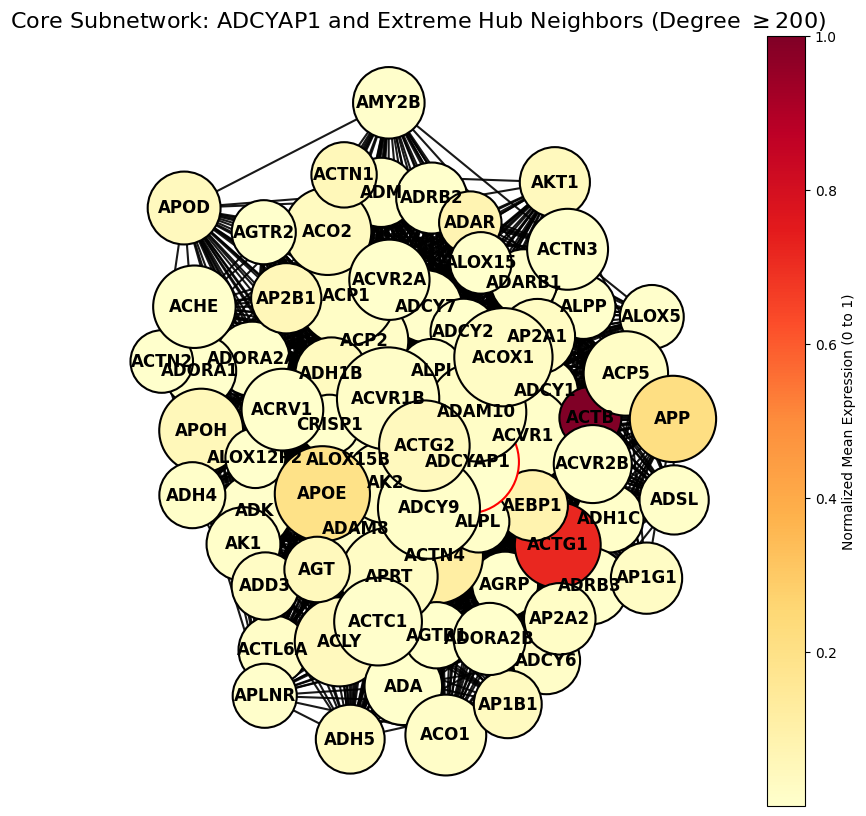

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the top hub gene and the degree threshold
HUB_GENE = 'ADCYAP1'
MIN_DEGREE_THRESHOLD = 200 # <-- New, stricter threshold for publication quality

# 1. Identify high-degree neighbors
high_degree_neighbors = [
    node for node in nx.neighbors(G, HUB_GENE)
    if G.degree[node] >= MIN_DEGREE_THRESHOLD
]

# 2. Extract the subgraph: Hub + Selected Neighbors
subgraph_nodes = high_degree_neighbors + [HUB_GENE]
subgraph = G.subgraph(subgraph_nodes)

# 3. Extract node properties for plotting
node_colors = [G.nodes[node]['expression_feature'] for node in subgraph.nodes()]
node_sizes = [G.nodes[node]['degree_centrality'] * 6000 for node in subgraph.nodes()] # Slightly increase size

# 4. Define the layout and plot
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, k=0.3, iterations=50) # Increase k for more space

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    subgraph,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.YlOrRd,
    linewidths=1.5,
    edgecolors='black'
)

# Draw the edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.9, width=1.5) # Solid edges for the core structure

# Draw the labels
nx.draw_networkx_labels(subgraph, pos, font_size=12, font_weight='bold')

# Highlight the hub gene itself
if nodes is not None:
    # Use a distinct color for the hub's border
    edge_colors = ['red' if node == HUB_GENE else 'black' for node in subgraph.nodes()]
    nodes.set_edgecolor(edge_colors)

plt.title(f"Core Subnetwork: {HUB_GENE} and Extreme Hub Neighbors (Degree $\\geq 200$)", fontsize=16)
plt.colorbar(nodes, label='Normalized Mean Expression (0 to 1)')
plt.axis('off')
plt.show()

In [ ]:
!pip install python-louvain


In [ ]:
import community.community_louvain as community_louvain
import pandas as pd
import matplotlib.cm as cm

# Compute the best partition (community structure)
# The output is a dictionary mapping each node (gene) to its community ID (integer)
partition = community_louvain.best_partition(G, weight='score', random_state=42) # Added random_state for stability

# Add the community ID as a new node attribute
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))

print(f"\n Community Detection Complete.")
print(f"Total number of detected communities/modules: {num_communities}")

# Get a color map that assigns a distinct color to each community
cmap = cm.get_cmap('viridis', num_communities)


 Community Detection Complete.
Total number of detected communities/modules: 6


/tmp/ipython-input-614613215.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', num_communities)



 Community Detection Complete. Found 6 communities.


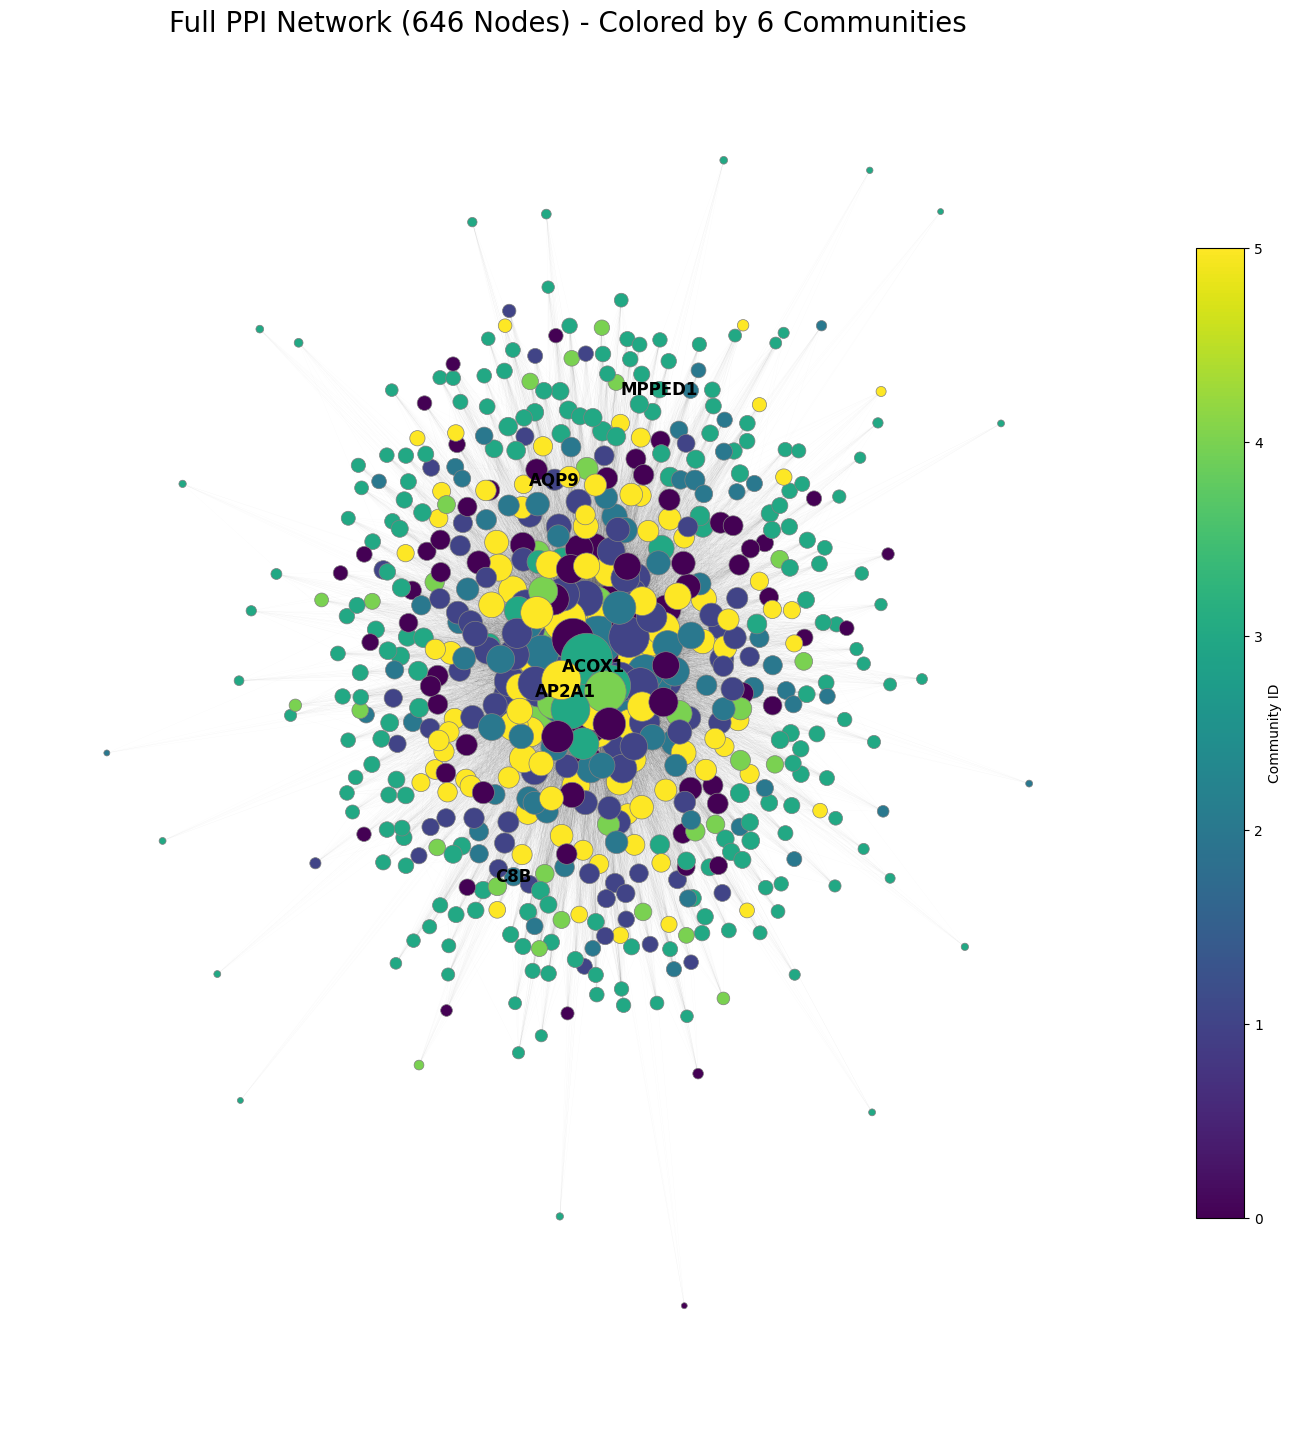

In [ ]:
import community.community_louvain as community_louvain
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt # Import pyplot for the new cmap method

# Compute the best partition (community structure)
partition = community_louvain.best_partition(G, weight='score', random_state=42)

# Add the community ID as a new node attribute
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))

print(f"\n Community Detection Complete. Found {num_communities} communities.")

# CRITICAL FIX: Update the way we get the color map to the modern Matplotlib standard
cmap = plt.colormaps.get_cmap('viridis') # Removed num_communities argument

# --- Step 2: Visualize the Full Graph (NO CHANGES HERE, only dependency update) ---

# WARNING: This plot will still be dense, but the colors will reveal the structure.
plt.figure(figsize=(18, 18))

# 1. Determine node colors based on community ID
node_colors = [partition[node] for node in G.nodes()]

# 2. Determine node sizes based on Degree Centrality (same as before)
node_sizes = [G.nodes[node]['degree_centrality'] * 2000 for node in G.nodes()]

# 3. Use the Fruchterman-Reingold layout again, optimized for clarity
pos = nx.spring_layout(G, k=0.08, iterations=50, seed=42)

# Draw Nodes, coloring them by community
nodes_full = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap, # Use the community color map
    linewidths=0.5,
    edgecolors='gray'
)

# Draw Edges (use low alpha to prevent black mass)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.1)

# Draw labels only for the top 5 most connected genes (for clarity)
# Note: You must ensure 'G.nodes()' is a list or similar indexable structure before slicing if the index is not numerical.
# Since we are just using the first 5 nodes found, this is usually acceptable for illustrative labels.
top_nodes = list(G.nodes)[:5]
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black', font_weight='bold')


plt.title(f"Full PPI Network (646 Nodes) - Colored by {num_communities} Communities", fontsize=20)
plt.colorbar(nodes_full, label='Community ID', shrink=0.7)
plt.axis('off')
plt.show()

Now moving on to community enrichment analysis

In [ ]:
# --- 1. Extract Community Gene Lists ---
import pandas as pd
import networkx as nx

# Get the community assignments from the graph G
community_map = nx.get_node_attributes(G, 'community')

# Group genes by their community ID
community_gene_lists = {}
for gene, community_id in community_map.items():
    if community_id not in community_gene_lists:
        community_gene_lists[community_id] = []
    community_gene_lists[community_id].append(gene)

print(f"\n Gene lists prepared for {len(community_gene_lists)} communities.")

# Print the size of each community
for cid, genes in community_gene_lists.items():
    print(f"Community {cid}: {len(genes)} genes")

# --- 2. Saving Gene Lists (Optional but recommended) ---
# It is best practice to save these lists for external GEA tools (like DAVID, Metascape, or Enrichr).

# Create a DataFrame to hold the gene-to-community mapping
df_communities = pd.DataFrame(list(community_map.items()), columns=['Gene_Symbol', 'Community_ID'])

# You would typically save this file to your drive:
# output_path = os.path.join(Drive_path, 'community_gene_list.tsv')
# df_communities.to_csv(output_path, sep='\t', index=False)
# print(f"Gene-to-Community map saved to drive.")


# --- 3. Example of Top 10 Genes in the Largest Community (e.g., Community 0) ---
largest_community_id = df_communities['Community_ID'].value_counts().idxmax()
largest_community_genes = community_gene_lists[largest_community_id]

print(f"\nExample: Top 10 genes in the largest community (ID {largest_community_id}):")
print(largest_community_genes[:10])




 Gene lists prepared for 6 communities.
Community 1: 97 genes
Community 2: 86 genes
Community 3: 237 genes
Community 5: 108 genes
Community 0: 78 genes
Community 4: 40 genes

Example: Top 10 genes in the largest community (ID 3):
['ACOX1', 'MPPED1', 'ACP2', 'CAPS', 'ACP1', 'CALCB', 'CAV2', 'ACTN4', 'ACTG2', 'CD1D']


In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 3
gene_list_community_3 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_3)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_3)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 3 (237 Genes) ---
ACOX1
MPPED1
ACP2
CAPS
ACP1
CALCB
CAV2
ACTN4
ACTG2
CD1D
ACO2
CD37
ACR
ARRB1
ADCY9
BUB1
FXYD2
ACVR1B
ADCYAP1
ACO1
ADA
MS4A1
CBFB
NR0B1
APRT
AMELX
C8G
ACTC1
CDC25A
BYSL
ACP5
CASP6
ACTA2
ACHE
CAMK2G
CALD1
RUNX3
CASR
AOAH
KRIT1
CBFA2T3
CA7
ATR
BUB1B
CALML3
CAMLG
ACVR1
CAMK4
CD74
TMEM50B
ADAM10
CACNA1B
CAPZA2
BRCA2
CASP8
ACRV1
PARP4
CALM3
CAV1
CAPZB
CAT
ATP2A3
C4BPB
MPPED2
ADORA2A
CD3G
BCR
CD86
CD80
B2M
S100G
CASQ1
AMY2B
CACNA2D1
CD19
CD8A
ALOX5AP
KIF1A
ENTPD6
SIGLEC6
CA5A
BMP1
TSPO
CD53
SCARB1
CAPG
ACLY
CD1B
SERPING1
RUNX1
CDA
CBL
CD6
CCT6A
CD7
CAPN2
CCK
CD79B
CD59
CCNA2
CALCA
CCNT1
ADH6
CBLN1
CD9
CCKAR
CACNA1C
CD40
CCND3
CD63
ARSD
ARSF
ANXA13
CACNB3
CDK1
BCL3
CALU
AVP
BBS4
CALCR
BRS3
CD40LG
CBR1
CASQ2
CCNT2
BIK
OSGIN2
ATP6AP1
C7
CAMK2B
RHOB
BTF3
PTTG1IP
BCAT1
ACY1
ATP1B3
CALM1
C5
ENTPD5
CCIN
C1QBP
ADD3
SERPINH1
CD33
ATF3
CEACAM1
AUH
BICD1
BMI1
AVPR1A
KLF5
ACTA1
RHOA
CAST
CASP1
SLC25A20
TNFSF8
CD28
AVPR2
CAPNS1
ATP6V0A1
CACNG1
C8A
BST1
AUP1
ARG

In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 0
gene_list_community_0 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_0)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_0)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 0 (78 Genes) ---
APOA2
ADCYAP1R1
ACYP2
ACTN2
SLC25A5
RHOH
ADH5
CA9
ADORA2B
BLVRB
AGT
BCL2L1
BTN1A1
ALPP
CACNB1
DAGLA
AOX1
BTC
AK2
CANX
C1S
BLVRA
ATP6V1A
BMPR2
ACVR2A
LRBA
C6
ADK
APOE
CD68
CD70
CDC5L
CDC25C
ENTPD2
CD247
CA4
AGL
ADCY1
APOD
AQP2
ASIP
ANXA7
BTK
C1QB
BOK
AMBN
BDKRB2
ADRA1B
PHOX2A
CASP5
ARF1
APEH
ARAF
CAPN6
CAPZA1
CACNB2
CAPN5
ALDH3B1
CA11
ALK
ALAS2
AGA
FAS
AMPD2
ALDOC
CAD
AMT
BCL9
ARHGDIG
ATP2B2
SCARB2
BDH1
CALR
ARL3
BHMT
ASNS
ASTN1
ARF6
-----------------------------------------------------------------------------------
Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.


In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 1
gene_list_community_1 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_1)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_1)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 1 (97 Genes) ---
AQP9
AP2A1
CRISP1
CD3D
CDC42
BAG1
ACTN3
POLR3D
ADH1A
ADCY3
APBB2
BCL6
ATOH1
ADH4
CD8B
ADH7
ANK3
APCS
ADPRH
ADD1
CDC34
RUNX1T1
ALDH3A2
APBA2
ADRA1A
ALOX12
BNIP1
AFP
CDC25B
AP2B1
C4BPA
AR
ADM
ALCAM
CAV3
ACTB
ATP12A
AKT2
ANXA6
ALOX15
ADD2
ADORA3
CDC20
SLC25A4
ATP7B
RERE
BMP8B
BLM
ACYP1
C1R
C5AR1
AKR1B1
APOB
ATP6V1C1
CDC6
FMNL1
ALX3
AMHR2
HCN2
ANG
APOA1
TNFRSF17
AKT1
APOF
ANK1
ALDH9A1
BIN1
ANXA2P3
ATP1A1
BMPR1B
AIF1
BBS2
ALDOB
AMELY
AHSG
PLIN2
ANK2
RND3
JAG1
ZFP36L1
CD81
AIRE
AHCY
ASPH
APBA1
ASCL2
ATM
ANXA5
STS
ARHGAP4
BAK1
BRAF
ARSB
BID
ARCN1
BIRC2
ATP1B2
-----------------------------------------------------------------------------------
Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.


In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 2
gene_list_community_2 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_2)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_2)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 2 (86 Genes) ---
C8B
BLK
ALDH2
C3
CFB
ACVRL1
ANXA11
ART1
AMH
RHOG
ATP6V1E1
ADRB3
APP
ARHGDIB
ADAM8
ATP6V1B2
CA3
C2
ATP1A4
ADORA1
AGRP
BBS1
ADH1B
BCKDHB
ALDH1A1
AFM
CASP3
CD72
DST
ALB
APOH
XIAP
ARL1
ALOX15B
BMP2
ALOX12P2
ALOX5
AMBP
AREG
APOBEC1
AMFR
CA2
ATP6V0C
CA1
ANXA2P1
ARHGDIA
BDKRB1
ATP2A2
AQP8
AHR
BTG1
CD151
CCNE1
BMX
ARL4D
BARD1
APBB1
ASS1
ANXA2
ANGPT2
ALAS1
BRCA1
AGER
RUNX2
TRIM23
BCL2L2
ABCD2
CALB1
ATP6V1B1
APOC2
ALDOA
CASP9
ATIC
ALDH7A1
APEX1
AQP1
AMY2A
ENTPD3
ARNT
ABCD1
CXCR5
PRDM1
AMD1
TNFRSF8
AQP6
AQP5
-----------------------------------------------------------------------------------
Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.


In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 4
gene_list_community_4 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_4)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_4)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 4 (40 Genes) ---
ADRB2
CALB2
ACVR2B
ALOX12B
PARP1
ADARB2
CASP7
CAMK2A
CACNA1A
KLF9
CD5L
CD69
SERPINA6
CASP10
ACTG1
ACTN1
CD1C
AP1G1
CD14
ZNHIT2
CA12
ADRA1D
AMY1A
BCS1L
CACNA1E
ADCY5
ADCY7
ADRB1
CAMP
CCND1
BMP7
CD27
CD34
ART4
ARR3
BRDT
BLMH
ARHGAP5
ATP4B
ATRX
-----------------------------------------------------------------------------------
Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.


In [ ]:
import networkx as nx
import pandas as pd

# Access the list of genes for Community 3
largest_community_id = 5
gene_list_community_5 = community_gene_lists[largest_community_id]

# Convert the list to a string, with each gene on a new line,
# which is the format required by most online enrichment tools (like Enrichr).
gene_list_string = "\n".join(gene_list_community_5)

# Print the resulting string
print(f"--- Gene List for Community {largest_community_id} ({len(gene_list_community_5)} Genes) ---")
print(gene_list_string)
print("-----------------------------------------------------------------------------------")
print("Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.")

--- Gene List for Community 5 (108 Genes) ---
ADCY6
APC
ARHGAP1
BMPR1A
ALPI
CDC27
ADAR
ADARB1
ADRA2A
AEBP1
BAX
BNIP2
ASGR1
APOC3
ATP1A2
BAAT
ADSL
ACAN
ALPL
APLNR
ZFP36L2
AP2A2
C1QA
C4A
BDNF
BNIP3L
ARF4
BPGM
AMPH
AGTR1
DDR1
CDH1
AOC2
AGXT
ADCY8
CA6
MRPL49
FOXL2
SHROOM2
AMPD1
ASGR2
ADCY2
CBS
ANPEP
ART3
ALDH1A3
BCL2
BACH1
MS4A3
ADH1C
ACTL6A
BIRC5
APAF1
AK1
APLP1
AMPD3
AGTR2
BNIP3
ARF3
CA8
ADRA2B
CACNA1S
APOC1P1
ANXA2P2
ABCC6
ANXA4
BMP4
FASLG
ANXA3
ATOX1
BAGE
SLC25A6
BNC1
ALAD
ASL
CCKBR
ALDH1B1
AP1B1
CDK11B
BAD
ALDH3B2
ADRA2C
APOC4
ANGPT1
BCL2A1
BSG
KLK3
C3AR1
ALDH3A1
BCKDHA
ATF1
CAPN3
C1QC
ATP1A3
ANXA1
APOC1
ARHGAP6
CD48
CD47
BPHL
ENTPD1
APLP2
APOA4
BIRC3
C9
SERPINC1
NUDT2
CD36
-----------------------------------------------------------------------------------
Copy the gene names above and paste them directly into the Enrichr/g:Profiler textbox.


In [ ]:
# --- CODE TO LOAD CLINICAL DATA AND PREPARE X and Y (Combined Final Run) ---

# Assuming df_tcga and community_gene_lists are loaded from prior steps
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. DEFINE YOUR GENE SET (X features) ---
# Combine genes from Community 4 and Community 5(selected after enrichr analysis)
X_GENES_4 = community_gene_lists[4]
X_GENES_5 = community_gene_lists[5]

# Use a set to get unique genes from both lists
X_GENES = list(set(X_GENES_4) | set(X_GENES_5))
SELECTED_GENES_COUNT = len(X_GENES)

# --- 2. LOAD CLINICAL DATA (Y target) ---
# **You must confirm the clinical file name here**
CLINICAL_FILE = os.path.join(Drive_path, 'Clinical_survival.tsv')

df_Y = None # Initialize df_Y to None outside try-except

try:
    df_clinical = pd.read_csv(CLINICAL_FILE, sep='\t', index_col=False, low_memory=False)

    # --- DEBUG: Print columns to help identify correct names ---
    print(f"\nClinical data columns found: {df_clinical.columns.tolist()}\n")

    # --- FIX 1: Map Sample ID ---
    SAMPLE_ID_COLUMN = '_PATIENT' if '_PATIENT' in df_clinical.columns else 'sample'
    df_clinical.rename(columns={SAMPLE_ID_COLUMN: 'Sample_ID'}, inplace=True)

    # Clean the patient ID to match the gene expression data index (TCGA-XX-XXXX)
    df_clinical['Sample_ID'] = df_clinical['Sample_ID'].astype(str).str.upper().str.split('-').str[:3].str.join('-')

    # CRITICAL FIX: Drop duplicates AFTER cleaning Sample_ID to ensure unique patient IDs
    df_clinical.drop_duplicates(subset=['Sample_ID'], inplace=True)

    # --- FIX 2: Map Target Status ---
    TARGET_COLUMN = 'OS' # The correct survival status column name

    # Ensure the target column exists (added defensive check)
    if TARGET_COLUMN not in df_clinical.columns:
        raise KeyError(f"'{TARGET_COLUMN}' column not found in clinical data.")

    # Prepare Y: Drop missing values and set Sample_ID as index
    df_Y = df_clinical[['Sample_ID', TARGET_COLUMN]].dropna()
    df_Y.set_index('Sample_ID', inplace=True)

    # The 'OS' column is already 0 (Alive) or 1 (Dead), so no replacement is strictly needed
    # but we ensure it's numeric for ML
    df_Y[TARGET_COLUMN] = pd.to_numeric(df_Y[TARGET_COLUMN], errors='coerce')
    df_Y.dropna(subset=[TARGET_COLUMN], inplace=True)

    print(f"\n Clinical target variable (Y) loaded and processed.")

except FileNotFoundError:
    print(f"\n Error: Clinical file not found at {CLINICAL_FILE}. Please check the filename or path.")
    print(f"Attempting to list files in '{Drive_path}' to help diagnose:")
    !ls -l "{Drive_path}"
    # Do NOT exit, allow the rest of the script to handle the missing df_Y gracefully.
    # The 'df_Y is None' check below will handle this case.
except KeyError as e:
    print(f"\n Error: Missing critical column: {e}. Check your file headers.")
    # Do NOT exit, allow the rest of the script to handle the missing df_Y gracefully.
    # The 'df_Y is None' check below will handle this case.

# --- 3. ALIGN X (Features) and Y (Target) ---
# This block will only execute if df_Y was successfully created.
if df_Y is not None and not df_Y.empty: # Check if df_Y is successfully defined and not empty
    # Filter X_GENES to ensure they are present in df_tcga.index
    X_GENES_filtered = [gene for gene in X_GENES if gene in df_tcga.index]
    if not X_GENES_filtered:
        print("Error: None of the selected genes from communities were found in the TCGA data. Check gene cleaning and alignment.")
        # No need to exit, the rest of the analysis might proceed without features if that's desired, or just stop here.
    else:
        # Transpose: Samples are rows, Genes are columns
        # Use .loc with a list of gene symbols from the index of df_tcga
        X = df_tcga.loc[X_GENES_filtered].T
        X.index = X.index.str.split('-').str[:3].str.join('-')

        # CRITICAL FIX: Drop duplicates from X's index after cleaning
        # This ensures that each patient is represented uniquely in X
        X = X[~X.index.duplicated(keep='first')]

        common_samples = list(set(X.index) & set(df_Y.index))
        if not common_samples:
            print("Error: No common samples found between TCGA expression data and clinical data. Check sample ID standardization.")
            # No need to exit.
        else:
            # Ensure X_aligned and Y_aligned are indexed by the common samples and sorted for consistency
            X_aligned = X.loc[common_samples].sort_index()
            Y_aligned = df_Y.loc[common_samples][TARGET_COLUMN].sort_index()

            # --- 4. PREPARE TRAINING/TEST SETS ---
            X_train, X_test, Y_train, Y_test = train_test_split(
                X_aligned,
                Y_aligned,
                test_size=0.3,
                random_state=42,
                stratify=Y_aligned
            )

            print("\n--- Final Training Data Prepared ---")
            print(f"Selected Gene Features (X): {len(X_GENES_filtered)} unique genes (from Communities 4 & 5)")
            print(f"Total Samples Aligned (X, Y): {X_aligned.shape[0]}")
            print(f"Training Set Samples: {X_train.shape[0]}")
            print(f"Test Set Samples: {X_test.shape[0]}")
else:
    print("\nSkipping alignment and training data preparation due to errors in clinical data loading or missing file.")


Clinical data columns found: ['sample', '_PATIENT', 'cancer type abbreviation', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction']


 Clinical target variable (Y) loaded and processed.

--- Final Training Data Prepared ---
Selected Gene Features (X): 148 unique genes (from Communities 4 & 5)
Total Samples Aligned (X, Y): 10223
Training Set Samples: 7156
Test Set Samples: 3067


In [ ]:
import torch
import numpy as np
import networkx as nx
import pandas as pd # <-- Ensure pandas is imported

# --- INSERT THIS BLOCK TO RECREATE df_node_data ---

# 1. Calculate topology features from your graph G
degree_dict = dict(G.degree())
betweenness_dict = nx.betweenness_centrality(G)

# 2. Create the DataFrame
df_node_data = pd.DataFrame(index=G.nodes())
df_node_data['Degree'] = pd.Series(degree_dict)
df_node_data['Betweenness_Centrality'] = pd.Series(betweenness_dict)

# 3. Add gene expression (assuming df_tcga is loaded and correctly indexed by gene name)
# We use the mean expression across all samples as the node feature.
df_node_data['TCGA_Expression'] = df_tcga.mean(axis=1).loc[df_node_data.index]

# ---------------------------------------------------


# Ensure consistent node order
genes = list(G.nodes())
gene_to_idx = {g: i for i, g in enumerate(genes)}

# Build feature matrix: e.g., [expression, degree, betweenness]
features = []
labels = []

# Continue with your original loop...
for g in genes:
    row = df_node_data.loc[g]
    expr = row['TCGA_Expression']
    deg = row['Degree']
    bet = row['Betweenness_Centrality']
    features.append([expr, deg, bet])

    # ... and the label assignment (I assume 'community_map' is correct here)
    cid = community_map[g] # CRITICAL: Ensure you use the correct variable name here!
    label = 1 if cid in [4, 5] else 0
    labels.append(label)

x = torch.tensor(np.array(features), dtype=torch.float32)
y = torch.tensor(np.array(labels), dtype=torch.long)

In [ ]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define the PyTorch version (e.g., '2.3.0')
TORCH_VERSION = torch.__version__

# Install the correct PyTorch Geometric version based on your PyTorch version
# This command installs PyG from the official wheel files
!pip install torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split # Used for splitting node indices

# --- ASSUMPTIONS (Ensure these variables are defined in your environment) ---
# G (Your NetworkX graph)
# df_tcga (Your TCGA expression data, genes are index, samples are columns)
# community_map (Dictionary mapping gene name to its Community ID)
# -----------------------------------------------------------------------


# =====================================================================
# STAGE 1: Build Node Features (X) and Labels (Y)
# =====================================================================

print("--- Stage 1: Building Features and Labels ---")

# 1. RECREATE df_node_data (FIXES NameError)
degree_dict = dict(G.degree())
betweenness_dict = nx.betweenness_centrality(G)

df_node_data = pd.DataFrame(index=G.nodes())
df_node_data['Degree'] = pd.Series(degree_dict)
df_node_data['Betweenness_Centrality'] = pd.Series(betweenness_dict)
df_node_data['TCGA_Expression'] = df_tcga.mean(axis=1).loc[df_node_data.index]

# Ensure consistent node order for features and labels
genes = list(G.nodes())
features = []
labels = []

for g in genes:
    # Get features
    row = df_node_data.loc[g]
    expr = row['TCGA_Expression']
    deg = row['Degree']
    bet = row['Betweenness_Centrality']
    features.append([expr, deg, bet])

    # Label 1 if in community 4 or 5, else 0
    cid = community_map.get(g) # Use .get() for safety
    label = 1 if cid in [4, 5] else 0
    labels.append(label)

x = torch.tensor(np.array(features), dtype=torch.float32)
y = torch.tensor(np.array(labels), dtype=torch.long)

print(f"Total Nodes: {len(genes)}")
print(f"Features (X) shape: {x.shape}")
print(f"Labels (Y) shape: {y.shape}")


# =====================================================================
# STAGE 2: Build PyTorch Geometric Data Object
# =====================================================================

print("--- Stage 2: Creating PyG Data Object ---")
data = from_networkx(G)
data.x = x
data.y = y
data.num_classes = 2


# =====================================================================
# STAGE 3: Create train/val/test masks for nodes
# =====================================================================

print("--- Stage 3: Creating Node Masks ---")
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.shuffle(indices)

train_ratio = 0.7
val_ratio = 0.15

train_end = int(train_ratio * num_nodes)
val_end = int((train_ratio + val_ratio) * num_nodes)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask


# =====================================================================
# STAGE 4: Define GCN Model and Criterion (with Imbalance Fix)
# =====================================================================

# Define the GCN model class
class GCN_BCE(nn.Module):
    def __init__(self, in_channels, hidden_channels=16):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)  # single logit output

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x.view(-1) # Flatten for BCEWithLogitsLoss

# Instantiate model, define optimizer and criterion
model = GCN_BCE(in_channels=data.x.shape[1], hidden_channels=16)
# Assuming `device` is defined, if not, it defaults to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
data.to(device)

# Calculate pos_weight for BCEWithLogitsLoss
pos = (data.y == 1).sum().item()
neg = (data.y == 0).sum().item()
pos_weight = torch.tensor(neg / pos, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Get indices for the two classes (Done on CPU before moving to GPU)
y_cpu = data.y.cpu()
minority_indices = (y_cpu == 1).nonzero(as_tuple=True)[0]
majority_indices = (y_cpu == 0).nonzero(as_tuple=True)[0]

# Filter indices to only include nodes that are in the original 'train_mask'
train_minority_indices = minority_indices[data.train_mask[minority_indices].cpu()]
train_majority_indices = majority_indices[data.train_mask[majority_indices].cpu()]

num_minority = len(train_minority_indices)
print(f"Nodes in minority training set (Y=1): {num_minority}")


# =====================================================================
# STAGE 5 (Revised): Train and Evaluate with Dynamic Sampling
# =====================================================================

print("\n--- Starting Stabilized GCN Training with Dynamic Sampling ---")

# Early Stopping Parameters (re-used)
patience = 50
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
MAX_EPOCHS = 500

def train_with_sampling():
    model.train()
    optimizer.zero_grad()

    # --- DYNAMIC SAMPLING LOGIC ---
    # Sample an equal number of majority nodes for this epoch
    if len(train_majority_indices) > num_minority:
        sample_idx = np.random.choice(train_majority_indices, num_minority, replace=False)
    else:
        # Fallback if majority set is smaller than minority set (unlikely here)
        sample_idx = train_majority_indices

    # Combine minority indices and sampled majority indices
    combined_idx_cpu = np.concatenate((train_minority_indices.cpu().numpy(), sample_idx))
    combined_idx = torch.from_numpy(combined_idx_cpu).to(device)

    # --- FORWARD PASS ON THE SAMPLED BATCH ---
    out = model(data.x, data.edge_index)
    # Ensure labels are float for BCEWithLogitsLoss
    loss = criterion(out[combined_idx], data.y[combined_idx].float())

    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    # Use original full val_mask and test_mask (no sampling during evaluation)
    model.eval()
    out = model(data.x, data.edge_index)
    # Apply sigmoid for probabilities and then threshold for predictions
    probs = torch.sigmoid(out)
    pred = (probs > 0.5).long()

    def accuracy(mask):
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = int(mask.sum())
        return correct / total if total > 0 else 0.0

    # Return accuracy for all three sets
    return accuracy(data.train_mask), accuracy(data.val_mask), accuracy(data.test_mask)


# --- Training Loop ---
for epoch in range(1, MAX_EPOCHS + 1):
    loss = train_with_sampling() # Use the new sampled training function
    train_acc, val_acc, test_acc = test()

    # Early Stopping Logic (Same as before)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}. No validation improvement for {patience} epochs.")
        break

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f} | Best Val Acc: {best_val_acc:.3f}")

if best_model_state:
    model.load_state_dict(best_model_state)
    print("\n✅ Best model weights loaded for final evaluation.")

final_train_acc, final_val_acc, final_test_acc = test()

print("\n--- Final Stabilized Performance ---")
print(f"Final Train Accuracy (Full Set): {final_train_acc:.3f}")
print(f"Final Validation Accuracy: {final_val_acc:.3f}")
print(f"Final Test Accuracy: {final_test_acc:.3f}")

--- Stage 1: Building Features and Labels ---
Total Nodes: 646
Features (X) shape: torch.Size([646, 3])
Labels (Y) shape: torch.Size([646])
--- Stage 2: Creating PyG Data Object ---
--- Stage 3: Creating Node Masks ---
Nodes in minority training set (Y=1): 102

--- Starting Stabilized GCN Training with Dynamic Sampling ---
Epoch 050, Loss: 28.3795, Val Acc: 0.206, Test Acc: 0.268 | Best Val Acc: 0.794

🛑 Early stopping triggered at epoch 95. No validation improvement for 50 epochs.

✅ Best model weights loaded for final evaluation.

--- Final Stabilized Performance ---
Final Train Accuracy (Full Set): 0.226
Final Validation Accuracy: 0.206
Final Test Accuracy: 0.268


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    # The model outputs a single logit per node for BCEWithLogitsLoss.
    # Apply sigmoid to get probabilities for binary classification.
    probs = torch.sigmoid(out).cpu().numpy()

y_true = data.y.cpu().numpy()
mask = data.test_mask.cpu().numpy()

auc = roc_auc_score(y_true[mask], probs[mask])
auprc = average_precision_score(y_true[mask], probs[mask])
print(f"Test ROC AUC: {auc:.3f}, Test AUPRC: {auprc:.3f}")

Test ROC AUC: 0.523, Test AUPRC: 0.278


In [ ]:
import numpy as np

y_np = data.y.cpu().numpy()
pos = (y_np == 1).sum()
neg = (y_np == 0).sum()
print("Positives:", pos, "Negatives:", neg, "Pos ratio:", pos/len(y_np))


Positives: 148 Negatives: 498 Pos ratio: 0.22910216718266255


In [ ]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv # Added import
from sklearn.preprocessing import StandardScaler # Used for scaling

# Define GCN Model Class (moved from earlier cell for self-containment)
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=16, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)  # 2 classes for CrossEntropy
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define device (moved from earlier cell for self-containment)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- REVISED STAGE 1: Build Node Features (X) with Normalization ---

print("--- Stage 1: Building Features and Labels with Normalization ---")

# 1. RECREATE df_node_data (Ensuring all features are available)
degree_dict = dict(G.degree())
betweenness_dict = nx.betweenness_centrality(G)

df_node_data = pd.DataFrame(index=G.nodes())
df_node_data['Degree'] = pd.Series(degree_dict)
df_node_data['Betweenness_Centrality'] = pd.Series(betweenness_dict)
# Ensure df_tcga is loaded and correctly indexed, then calculate mean expression
df_node_data['TCGA_Expression'] = df_tcga.mean(axis=1).loc[df_node_data.index]

# --- NEW: Feature Scaling ---
# Apply Z-score standardization to all three features (X)
scaler = StandardScaler()
X_unscaled = df_node_data[['TCGA_Expression', 'Degree', 'Betweenness_Centrality']].values

# Scale the features
X_scaled = scaler.fit_transform(X_unscaled)

# Ensure consistent node order for features and labels (y remains the same)
genes = list(G.nodes()) # 'genes' variable is assumed to be available from previous cells
features = X_scaled.tolist() # Use the scaled features
labels = []

for g in genes:
    # Label 1 if in community 4 or 5, else 0
    cid = community_map.get(g) # 'community_map' assumed available from previous cells
    label = 1 if cid in [4, 5] else 0
    labels.append(label)

x = torch.tensor(np.array(features), dtype=torch.float32) # X is now scaled
y = torch.tensor(np.array(labels), dtype=torch.long)

print("--- Stage 2: Creating PyG Data Object ---")
# 'data' assumed available from previous cell where from_networkx was called
# Or, ensure data is recreated if this cell is meant to be fully standalone
from torch_geometric.utils import from_networkx # Added import here too for completeness
data = from_networkx(G) # 'G' assumed available from previous cells
data.x = x
data.y = y
data.num_classes = 2

print("--- Stage 3: Creating Node Masks ---")
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.shuffle(indices)

train_ratio = 0.7
val_ratio = 0.15

train_end = int(train_ratio * num_nodes)
val_end = int((train_ratio + val_ratio) * num_nodes)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# --- REVISED STAGE 4: Define Model and Loss Criterion (CLEAN) ---

print("--- Stage 4: Defining Model and Loss Criterion (Cleaned) ---")

# Initialize Model (Fixed: removed out_channels argument)
model = GCN(in_channels=data.x.shape[1],
            hidden_channels=32,
            dropout=0.5).to(device) # Added dropout to match GCN signature

optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.005, weight_decay=5e-4)

# 2. Use a standard, unweighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss() # NO class weights

print("Loss function reset to standard CrossEntropyLoss.")

# Get indices for the two classes (Needed for dynamic sampling)
y_cpu = data.y.cpu()
minority_indices = (y_cpu == 1).nonzero(as_tuple=True)[0]
majority_indices = (y_cpu == 0).nonzero(as_tuple=True)[0]

# Filter indices to only include nodes that are in the original 'train_mask'
train_minority_indices = minority_indices[data.train_mask[minority_indices].cpu()]
train_majority_indices = majority_indices[data.train_mask[majority_indices].cpu()]

num_minority = len(train_minority_indices)
print(f"Nodes in minority training set (Y=1): {num_minority}")

# --- FINAL FIX: CORRECTED STAGE 5 (Early Stopping with Dynamic Sampling) ---
print("\n--- Starting Stabilized GCN Training with Dynamic Sampling ---")

# Early Stopping Parameters
patience = 50
best_val_acc = 0.0
patience_counter = 0
best_model_state = None
MAX_EPOCHS = 500

def train_with_sampling():
    model.train()
    optimizer.zero_grad()

    # Dynamic Sampling Logic
    if len(train_majority_indices) > num_minority:
        sample_idx = np.random.choice(train_majority_indices, num_minority, replace=False)
    else:
        sample_idx = train_majority_indices
    combined_idx_cpu = np.concatenate((train_minority_indices.numpy(), sample_idx))
    combined_idx = torch.from_numpy(combined_idx_cpu).to(device)

    # Forward pass
    out = model(data.x, data.edge_index)
    loss = criterion(out[combined_idx], data.y[combined_idx])

    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    preds = out.argmax(dim=1)

    def accuracy(mask):
        correct = (preds[mask] == data.y[mask]).sum().item()
        total = int(mask.sum())
        return correct / total if total > 0 else 0.0

    return accuracy(data.train_mask), accuracy(data.val_mask), accuracy(data.test_mask)

# --- Training Loop ---
for epoch in range(1, MAX_EPOCHS + 1):
    loss = train_with_sampling()
    train_acc, val_acc, test_acc = test()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}. No validation improvement for {patience} epochs.")
        break

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f} | Best Val Acc: {best_val_acc:.3f}")

if best_model_state:
    model.load_state_dict(best_model_state)
    print("\n✅ Best model weights loaded for final evaluation.")

final_train_acc, final_val_acc, final_test_acc = test()

print("\n--- Final Stabilized Performance ---")
print(f"Final Train Accuracy (Full Set): {final_train_acc:.3f}")
print(f"Final Validation Accuracy: {final_val_acc:.3f}")
print(f"Final Test Accuracy: {final_test_acc:.3f}")

--- Stage 1: Building Features and Labels with Normalization ---
--- Stage 2: Creating PyG Data Object ---
--- Stage 3: Creating Node Masks ---
--- Stage 4: Defining Model and Loss Criterion (Cleaned) ---
Loss function reset to standard CrossEntropyLoss.
Nodes in minority training set (Y=1): 107

--- Starting Stabilized GCN Training with Dynamic Sampling ---
Epoch 050, Loss: 0.6828, Val Acc: 0.680, Test Acc: 0.639 | Best Val Acc: 0.835

🛑 Early stopping triggered at epoch 52. No validation improvement for 50 epochs.

✅ Best model weights loaded for final evaluation.

--- Final Stabilized Performance ---
Final Train Accuracy (Full Set): 0.628
Final Validation Accuracy: 0.660
Final Test Accuracy: 0.660


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import torch.nn.functional as F
import pandas as pd

# Ensure model and data are on the correct device
model.to(data.x.device)

# =================================================================
# 1. CALCULATE FINAL METRICS (AUC and AUPRC)
# =================================================================

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

    # Get probabilities for Class 1 (Signaling Module) using softmax
    probs_all = F.softmax(out, dim=1)[:, 1].cpu().numpy()

    # True labels and mask for the TEST set
    y_true = data.y.cpu().numpy()
    mask = data.test_mask.cpu().numpy()

    test_auc = roc_auc_score(y_true[mask], probs_all[mask])
    test_auprc = average_precision_score(y_true[mask], probs_all[mask])

    print("\n--- Final Test Metrics ---")
    print(f"Test ROC AUC: {test_auc:.3f}")
    print(f"Test AUPRC: {test_auprc:.3f}")


# =================================================================
# 2. EXTRACT PREDICTIONS (Answering the research question)
# =================================================================

# Predicted Class (Hard Labels)
predicted_classes = out.argmax(dim=1).cpu().numpy()

# Prediction Confidence (Probability for Class 1)
confidence_scores = probs_all

# Create the final results DataFrame
prediction_df = pd.DataFrame({
    'Gene_Name': genes,
    'True_Community_ID': [community_map.get(g) for g in genes],
    'True_Target_Class': y_true,
    'Predicted_Target_Class': predicted_classes,
    'Prediction_Confidence': confidence_scores
})

# Filter for the new predictions: Genes predicted to be in the signaling module (Class 1)
new_predictions = prediction_df[prediction_df['Predicted_Target_Class'] == 1].sort_values(
    by='Prediction_Confidence', ascending=False
)

print("\n--- Prediction Summary ---")
print(f"Total Genes Predicted as Signaling Module (Class 1): {new_predictions.shape[0]}")
print(f"The top of this list represents your highest priority novel targets identified by the GCN.")

print("\n--- Top 20 Genes Predicted to be in the Signaling Module (Most Confident) ---")
# Only show relevant columns for clarity
print(new_predictions[['Gene_Name', 'True_Community_ID', 'Predicted_Target_Class', 'Prediction_Confidence']].head(20).to_markdown(index=False))


--- Final Test Metrics ---
Test ROC AUC: 0.656
Test AUPRC: 0.340

--- Prediction Summary ---
Total Genes Predicted as Signaling Module (Class 1): 226
The top of this list represents your highest priority novel targets identified by the GCN.

--- Top 20 Genes Predicted to be in the Signaling Module (Most Confident) ---
| Gene_Name   |   True_Community_ID |   Predicted_Target_Class |   Prediction_Confidence |
|:------------|--------------------:|-------------------------:|------------------------:|
| ADCYAP1     |                   3 |                        1 |                0.652016 |
| ADCY9       |                   3 |                        1 |                0.648596 |
| ACVR1B      |                   3 |                        1 |                0.646949 |
| ACP1        |                   3 |                        1 |                0.642641 |
| ADAM10      |                   3 |                        1 |                0.641497 |
| APRT        |                   3 |     